# CAMELS Multifield Dataset

Examining 2D simulations from the CAMELS Multifield Dataset (CMD), employing deep learning to understand underlying physics and evaluate the predictive value of various map types on cosmological parameters, emphasizing key parameters for universe analysis.

This is the main script for the project

In [1]:
# Initial Imports (more later in script)
import numpy as np
import matplotlib.pyplot as plt 
import urllib.request
import importlib
import os 
import tensorflow as tf
import gc

# Import own script
import CAMELS_LOADER

In [2]:
# Make sure we have the latest version of the CAMELS dataset loader file (used for testing purposes)
importlib.reload(CAMELS_LOADER)

<module 'CAMELS_LOADER' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\CAMELS_LOADER.py'>

### CAMELS_loader Dataset builder:
Brief overview of the self-built dataset class used throughout. This dataset carries out the data preprocessing and train, test and validation split.

In [17]:
# Create a new dataset with map B loaded
CAMELS_dataset = CAMELS_LOADER.CAMELS_Dataset(maps=['B'])
# Generate the dataset
CAMELS_dataset.generate_dataset()
print(CAMELS_dataset.get_summary())

File Maps_B_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
{'maps': ['B'], 'normalised': 'False', 'train_num': 792, 'val_num': 99, 'test_num': 99}


In [4]:
CAMELS_dataset.normalise()  # Normalise the dataset
# Get a summary of the current dataset summary
CAMELS_dataset.get_summary()

{'maps': ['B'],
 'normalised': 'True: By Map',
 'train_num': 792,
 'val_num': 99,
 'test_num': 99}

In [5]:
# Add some more datasets accounting for already loaded dataset and invalid dataset test cases
CAMELS_dataset.add_maps(['B', 'T', 'joashg'])
CAMELS_dataset.generate_dataset()
CAMELS_dataset.get_summary()

Map B already in dataset, skipping...
        'https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_joashg_IllustrisTNG_1P_z=0.00.npy'
        to ./data/Maps_joashg_IllustrisTNG_1P_z=0.00.npy. This may take a while...
Cannot find file: 'Maps_joashg_IllustrisTNG_1P_z=0.00.npy'. Skipping...
File Maps_T_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
All new maps loaded. Call method generate_dataset to regenerate the new dataset for the new maps


{'maps': ['B', 'T'],
 'normalised': 'False',
 'train_num': 1584,
 'val_num': 198,
 'test_num': 198}

In [6]:
CAMELS_dataset.normalise()  # Perform a by map normalisation of the dataset
CAMELS_dataset.get_summary()

{'maps': ['B', 'T'],
 'normalised': 'True: By Map',
 'train_num': 1584,
 'val_num': 198,
 'test_num': 198}

In [7]:
# Delete an item from the dataset
del CAMELS_dataset[['T']]
CAMELS_dataset.generate_dataset(shuffle=False)
CAMELS_dataset.get_summary()

Map T removed from dataset


{'maps': ['B'],
 'normalised': 'False',
 'train_num': 792,
 'val_num': 99,
 'test_num': 99}

(792, 256, 256)
params.shape (792, 6)


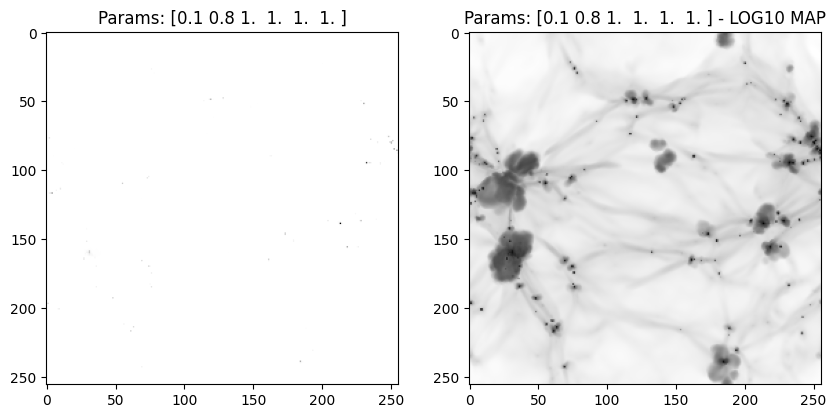

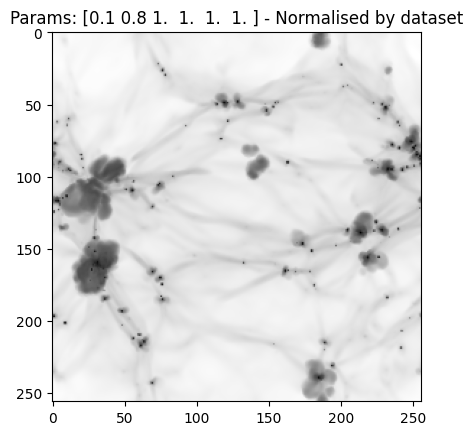

In [8]:
# Check the images are correct by plotting

print(CAMELS_dataset.train_x.shape)
print("params.shape",CAMELS_dataset.train_y.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.array(CAMELS_dataset.train_x[0]),cmap="binary")
ax[1].imshow(np.log10(CAMELS_dataset.train_x[0]),cmap="binary")

ax[0].set_title(f'Params: {CAMELS_dataset.train_y[0]}')
ax[1].set_title(f'Params: {CAMELS_dataset.train_y[0]} - LOG10 MAP')

# Normalise dataset and now plot
CAMELS_dataset.normalise(shuffle=False)
fig, ax = plt.subplots()
ax.imshow(np.log10(CAMELS_dataset.train_x[0]),cmap="binary")
ax.set_title(f'Params: {CAMELS_dataset.train_y[0]} - Normalised by dataset');

This is useful to show that in normalising the dataset we get a very similar map to the log10 map

## Hyperparameter tuning

In the next section I carry out hyperparameter tuning using SKlearn parameter grid from a custom script : HyperTuneTorch

NOTE: this uses pytorch rather than tensorflow

In [18]:
# Reset dataset for hyperparameter tuning - currently uses the Z field for hyperparameter tuning
del CAMELS_dataset
CAMELS_dataset = CAMELS_LOADER.CAMELS_Dataset(['Z'])

File Maps_Z_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...


In [19]:
CAMELS_dataset.add_maps(['Z'])
CAMELS_dataset.generate_dataset()
CAMELS_dataset.normalise()
CAMELS_dataset.get_summary()

Map Z already in dataset, skipping...
All new maps loaded. Call method generate_dataset to regenerate the new dataset for the new maps


{'maps': ['Z'],
 'normalised': 'True: By Map',
 'train_num': 792,
 'val_num': 99,
 'test_num': 99}

In [11]:
import HyperTuneTorch

import torch
from sklearn.model_selection import ParameterGrid

In [26]:
importlib.reload(HyperTuneTorch)

<module 'HyperTuneTorch' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\HyperTuneTorch.py'>

In [20]:
# Generate data -- Torch tensors
X = torch.from_numpy(CAMELS_dataset.train_x)
y = torch.from_numpy(CAMELS_dataset.train_y)

X = X.unsqueeze(1)
X = X.float()
y = y.float()

### OLD METHOD OF HYPERPARAMETER TUNING

The old method for hyperparameter tuning including the original config_space it was originally carried out for. This config space is over 4000 different combinations.
The main change made from the old method of hyperparameter tuning being autosaving of configurations and best models

In [13]:
# Define a cost function of loss and params for evaluating the models
def cost_fun(loss, params):
    return loss**7 * params


# Configuration space to search -- Note this currently does not account for time taken to train
config_space = ParameterGrid({
    'input_shape': [(1, 256, 256)],
    'lr': [0.2, 0.25],                      # Learning rate of the SGD optimizer
    'in_channels': [1],                     # Number of channels into the model -- NOTE SHOULD BE SAME AS FIRST DIM ON INPUT SHAPE
    'first_channels': [4, 8],               # Number of out channels in first convolutional layer
    'out_channels': [16, 32],               # Number of out channels in second convolutional layer
    'out_channels_2': [32, 64],             # Number of out channels is third convolutional layer
    'kernel_size': [2, 3, 4],               # kernel size in all 3 models
    'mom': [0.6, 0.75],                     # Momentum for the SGD optimizer
    'batch_size': [64, 128],                # Batch sizes
    'pool_size': [2, 3, 4],                 # Pool size for maxPooling layer
    'strides': [2, 3],                      # Strides in maxPooling layer
    'dropout': [0.3, 0.4],                  # Dropout layer probability
    'dense': [75, 86],                      # How many neurons in final layer
    'loss': ['mean_squared_error'],         # Loss function to use
    'epochs': [20],                         # Number of epochs to run for
    'patience_self': [8],                   # Number of epochs to wait before quitting trial when model performing worse than itself
    'tolerance_self': [0.001],              # Tolerance for early stopping with val_loss within self
    'patience_total': [5],                  # Number of epochs to wait before early stopping when model performing worse than best model
    'tol_mult': [3],                        # Multiplicity factor for how much worse the model has to perform than the best model before early stopping
    'cost_func': [cost_fun],                # Function of loss and model_params to evaluate overall cost of model
    'weight_decay': [1e-5]
})

In [250]:
print(f'Using GPU: {torch.cuda.is_available()}')
print(f'Config space size: {len(config_space)}')

try:
    best_config, best_loss, best_cost = HyperTuneTorch.hyperparameter_tuning(config_space, X, y, num_folds=3)
    print("Best Configuration:", best_config)
    print("Best Loss:", best_loss)
    print('Best Cost:', best_cost)
except KeyboardInterrupt:
    print('Ending...')
    #print("Best Configuration -- RUN STOPPED EARLY:", HyperTuneTorch.best_config) -- This line used to work, however now throws an error due to updating the base script

Using GPU: True
Config space size: 576
Starting...
466 configs left out of original 576
Config: 0/466
Ending...


## HyperParam Tuning Updated version:
- Saving to file rather than printing (which also means the same configs aren't tested multiple times for no reason)
- using a different config space for further refinement on model selection

As the runs can now be stopped and started whenever, this has been run multiple times, so the config_space defined below is the 4th or 5th different config space I have run this for. All configs can be found by loading the save file (or calling HyperTuneTorch.load_dt_run([{}]) and accessing the 'configs_tested' key) which has all loaded and saved configurations tested.

In [24]:
# Define a cost function of loss and params for evaluating the models
def cost_fun(loss, params):
    return loss**7 * params


# Configuration space to search -- Note this currently does not account for time taken to train
config_space = ParameterGrid({
    'input_shape': [(1, 256, 256)],
    'lr': [0.1, 0.15],                      # Learning rate of the SGD optimizer
    'in_channels': [1],                     # Number of channels into the model 
    'first_channels': [8, 16, 32],               # Number of out channels in first convolutional layer
    'out_channels': [16, 32, 64],               # Number of out channels in second convolutional layer
    'out_channels_2': [32, 64],             # Number of out channels is third convolutional layer
    'kernel_size': [4],               # kernel size in all 3 models
    'mom': [0.75, 0.9],                     # Momentum for the SGD optimizer
    'batch_size': [64],                # Batch sizes
    'pool_size': [3, 4],                 # Pool size for maxPooling layer
    'strides': [2, 3],                      # Strides in maxPooling layer
    'dropout': [0.3],                  # Dropout layer probability
    'dense': [70, 86],                      # How many neurons in final layer
    'loss': ['mean_squared_error'],         # Loss function to use
    'epochs': [20],                         # Number of epochs to run for
    'patience_self': [20],                   # Number of epochs to wait before quitting trial when model performing worse than itself
    'tolerance_self': [0.0001],              # Tolerance for early stopping with val_loss within self
    'patience_total': [5],                  # Number of epochs to wait before early stopping when model performing worse than best model
    'tol_mult': [3],                        # Multiplicity factor for how much worse the model has to perform than the best model before early stopping
    'cost_func': [cost_fun],                # Function of loss and model_params to evaluate overall cost of model
    'weight_decay': [1e-5]
})
print(len(config_space))

576


In [27]:
print(f'Using GPU: {torch.cuda.is_available()}')
print(f'Config space size: {len(config_space)}')

best_config, best_loss, best_cost = HyperTuneTorch.hyperparameter_tuning(config_space, X, y, num_folds=3)

Using GPU: True
Config space size: 576
Starting...
576 configs left out of original 576
Config: 0/576
Config: 1/576
Config: 2/576
Config: 3/576
Config: 4/576
Config: 5/576
Config: 6/576
Config: 7/576
Config: 8/576
Config: 9/576
Config: 10/576
Config: 11/576
Config: 12/576
Config: 13/576
Config: 14/576
Config: 15/576
Config: 16/576
Config: 17/576
Config: 18/576
Config: 19/576
Config: 20/576
Config: 21/576
Config: 22/576
Config: 23/576
Config: 24/576
Config: 25/576
Config: 26/576
Config: 27/576
Config: 28/576
Config: 29/576
Config: 30/576
Config: 31/576
Config: 32/576
Config: 33/576
Config: 34/576
Config: 35/576
Config: 36/576
Config: 37/576
Config: 38/576
Config: 39/576
Config: 40/576
Config: 41/576
Config: 42/576
Config: 43/576
Config: 44/576
Config: 45/576
Config: 46/576
Config: 47/576
Config: 48/576
Config: 49/576
Config: 50/576
Config: 51/576
Config: 52/576
Config: 53/576
Config: 54/576
Config: 55/576
Config: 56/576
Config: 57/576
Config: 58/576
Config: 59/576
Config: 60/576
Config:

KeyboardInterrupt: 

Note: KeyboardInterrupt showing run stopping early while still saving the 106 values already tested.

In [28]:
# Getting the best Configs, both on the cost function and pure validation loss

save, _ = HyperTuneTorch.load_dt_run([{}])
for i, item in enumerate(save.items()):
    if item[0] == 'configs_tested':
        break
    print(f"{item[0]}: {item[1]}")
best_config = save['best_config_by_cost']
 

best_config_by_cost: {'batch_size': 64, 'cost_func': <function cost_fun at 0x000001FD21ED7760>, 'dense': 50, 'dropout': 0.4, 'epochs': 20, 'first_channels': 32, 'in_channels': 1, 'input_shape': (1, 256, 256), 'kernel_size': 4, 'loss': 'mean_squared_error', 'lr': 0.15, 'mom': 0.75, 'out_channels': 16, 'out_channels_2': 32, 'patience_self': 8, 'patience_total': 5, 'pool_size': 5, 'strides': 3, 'tol_mult': 3, 'tolerance_self': 0.001, 'weight_decay': 1e-05}
best_cost: 0.009196457453072071
best_config_loss: 0.09533492724100749
best_config_by_cost_params: 95732
best_config_by_loss: {'batch_size': 64, 'cost_func': <function cost_fun at 0x000001FD21ED7760>, 'dense': 70, 'dropout': 0.3, 'epochs': 20, 'first_channels': 8, 'in_channels': 1, 'input_shape': (1, 256, 256), 'kernel_size': 4, 'loss': 'mean_squared_error', 'lr': 0.2, 'mom': 0.9, 'out_channels': 64, 'out_channels_2': 32, 'patience_self': 8, 'patience_total': 5, 'pool_size': 3, 'strides': 3, 'tol_mult': 3, 'tolerance_self': 0.001, 'weigh

### HyperParam tuning outcome:

The hyperparameter tuning has given us 2 different models, one with the lower absolute loss and one with the lower cost. We will continue here using the best cost model and now train the model for longer using this config.

In [29]:
# Generate the model
config = best_config
# Train for longer
config['epochs'] = 400
config['patience_self'] = 50
config['tolerance_self'] = 0.00001

model = HyperTuneTorch.NeuralNetwork(config)

In [30]:
# Get a summary of the model
from torchsummary import summary

summary(model, config['input_shape'], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 253, 253]             544
         MaxPool2d-2           [-1, 32, 83, 83]               0
            Conv2d-3           [-1, 16, 80, 80]           8,208
         MaxPool2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 23, 23]           8,224
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Dropout-7                 [-1, 1568]               0
            Linear-8                   [-1, 50]          78,450
           Dropout-9                   [-1, 50]               0
           Linear-10                    [-1, 6]             306
Total params: 95,732
Trainable params: 95,732
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 18.33
Params size (MB): 0.37
Estimated To

To train the model we can use train_model from [...ModelTraining...] script which is an adapted version of the model_train method in HyperTuneTorch.

In [31]:
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=1568, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=6, bias=True)
)


In [32]:
import ModelTraining

In [33]:
importlib.reload(ModelTraining)

<module 'ModelTraining' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\ModelTraining.py'>

In [34]:
X_train = CAMELS_dataset.train_x
y_train = CAMELS_dataset.train_y
X_val = CAMELS_dataset.val_x
y_val = CAMELS_dataset.val_y
# Convert data from numpy to torch
X_train = torch.from_numpy(X_train).unsqueeze(1).float()
y_train = torch.from_numpy(y_train).float()

X_val = torch.from_numpy(X_val).unsqueeze(1).float()
y_val = torch.from_numpy(y_val).float()

In [35]:
history, model = ModelTraining.train_model(config, X_train, y_train, X_val, y_val, model)

Epoch 0/400 -- Train Loss 0.20377004146575928 -- Val Loss -- 0.09421089291572571 -- Best Val Loss -- 0.09421089291572571
Epoch 1/400 -- Train Loss 0.1981879621744156 -- Val Loss -- 0.09327614307403564 -- Best Val Loss -- 0.09327614307403564
Epoch 2/400 -- Train Loss 0.2004048079252243 -- Val Loss -- 0.09350942820310593 -- Best Val Loss -- 0.09327614307403564
Epoch 3/400 -- Train Loss 0.20235678553581238 -- Val Loss -- 0.09338918328285217 -- Best Val Loss -- 0.09327614307403564
Epoch 4/400 -- Train Loss 0.20231623947620392 -- Val Loss -- 0.09340617060661316 -- Best Val Loss -- 0.09327614307403564
Epoch 5/400 -- Train Loss 0.20051822066307068 -- Val Loss -- 0.09336599707603455 -- Best Val Loss -- 0.09327614307403564
Epoch 6/400 -- Train Loss 0.2019035518169403 -- Val Loss -- 0.0934918001294136 -- Best Val Loss -- 0.09327614307403564
Epoch 7/400 -- Train Loss 0.20077021420001984 -- Val Loss -- 0.09346266090869904 -- Best Val Loss -- 0.09327614307403564
Epoch 8/400 -- Train Loss 0.20227098

In [36]:
# Evaluate loss on training data
x_test = CAMELS_dataset.test_x
y_test = CAMELS_dataset.test_y
# Convert data from numpy to torch
x_test = torch.from_numpy(x_test).unsqueeze(1).float()
y_test = torch.from_numpy(y_test).float()

test_loss = ModelTraining.test_model(x_test, y_test, model)
print(f'Model test loss for field(s) {list(CAMELS_dataset.maps.keys())}: {test_loss}')

Model test loss for field(s) ['Z']: 0.07680218666791916


In [264]:
# Save the model as an onnx file for visualisation with Netron
torch.onnx.export(HyperTuneTorch.NeuralNetwork(best_config), torch.zeros(size=(990, 1, 256, 256)), 'model_vis.onnx')

In [38]:
from matplotlib.patches import Ellipse as Ellipse

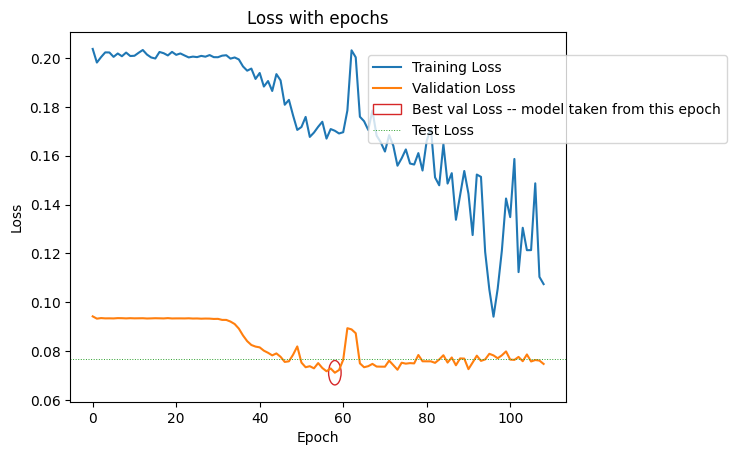

In [39]:
# Plotting loss graphs

fig, ax = plt.subplots()

ax.set_title('Loss with epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ls = np.min(history['val_loss_list'])
ind = history['val_loss_list'].index(ls)

circle = Ellipse((ind, ls), 3, 0.01, color='tab:red', fill=False, label="Best val Loss -- model taken from this epoch")

ax.plot(history['train_loss_list'], label='Training Loss')
ax.plot(history['val_loss_list'], label='Validation Loss')
ax.add_patch(circle)
#ax.plot([history['val_loss_list'][86], 86], linestyle='-', color='tab:red', lw=1, label="Best val Loss -- model taken from this epoch")
ax.axhline(test_loss, linestyle=':', color='tab:green', lw=0.7, label='Test Loss')

plt.legend(loc=(0.6,0.7))

## Data augmentation -- does it help for this example?

Carrying out offline data augmentation and comparing it to online data augmentation 

In [50]:
from torchvision.transforms import v2

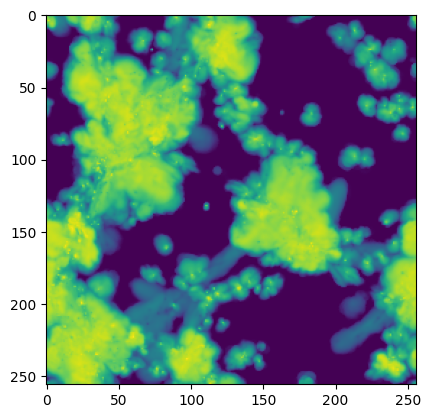

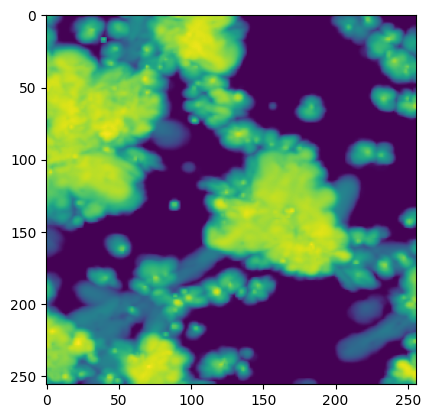

In [209]:
transforms_1 = v2.Compose([
    v2.RandomHorizontalFlip(p=1)
])
transforms_2 = v2.Compose([
    v2.RandomResizedCrop((200, 200), antialias=True),
    v2.Resize(size=(256, 256))
])
an = transforms_2(X_train.squeeze())
#transforms_2(X_train).shape
fig, ax = plt.subplots()
ax.imshow(np.log10(X_train[0, 0]))
fig, ax = plt.subplots()
ax.imshow(np.log10(an[0]))

ABOVE: An example of random cropping and resizing.
NOTE: Tried augmentation by random cropping, flipping vertically, rotating -- all just made final loss worse

In [210]:
print(X_train.shape)

aug_X_train_1 = transforms_1(X_train)

print(aug_X_train_1.shape)

new_X_train = torch.concatenate((X_train, aug_X_train_1))
new_y_train = torch.concatenate((y_train, y_train))


print(new_X_train.shape)
print(new_y_train.shape)

torch.Size([792, 1, 256, 256])
torch.Size([792, 1, 256, 256])
torch.Size([1584, 1, 256, 256])
torch.Size([1584, 6])


In [53]:
# Set up new model
del model
torch.cuda.empty_cache()
gc.collect()

model = HyperTuneTorch.NeuralNetwork(config)

In [54]:
# Carry out training for dataset of double the size
history, model = ModelTraining.train_model(config, new_X_train, new_y_train, X_val, y_val, model)

Epoch 0/400 -- Train Loss 0.05205894634127617 -- Val Loss -- 0.06933214515447617 -- Best Val Loss -- 0.06933214515447617
Epoch 1/400 -- Train Loss 0.049833063036203384 -- Val Loss -- 0.0677177757024765 -- Best Val Loss -- 0.0677177757024765
Epoch 2/400 -- Train Loss 0.05025952309370041 -- Val Loss -- 0.06768620014190674 -- Best Val Loss -- 0.06768620014190674
Epoch 3/400 -- Train Loss 0.049902353435754776 -- Val Loss -- 0.06765808910131454 -- Best Val Loss -- 0.06765808910131454
Epoch 4/400 -- Train Loss 0.05035131424665451 -- Val Loss -- 0.06771522760391235 -- Best Val Loss -- 0.06765808910131454
Epoch 5/400 -- Train Loss 0.04993055388331413 -- Val Loss -- 0.06777016818523407 -- Best Val Loss -- 0.06765808910131454
Epoch 6/400 -- Train Loss 0.050007741898298264 -- Val Loss -- 0.06772274523973465 -- Best Val Loss -- 0.06765808910131454
Epoch 7/400 -- Train Loss 0.04988822713494301 -- Val Loss -- 0.06770878285169601 -- Best Val Loss -- 0.06765808910131454
Epoch 8/400 -- Train Loss 0.050

In [55]:
test_loss = ModelTraining.test_model(x_test, y_test, model)
print(f'Model test loss for field(s) {list(CAMELS_dataset.maps.keys())}: {test_loss}')

Model test loss for field(s) ['Z']: 0.11351260542869568


### Online data augmentation

In [56]:
# Set up new model
del model
torch.cuda.empty_cache()
gc.collect()

model = HyperTuneTorch.NeuralNetwork(config)

In [57]:
transforms_online = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5)
])

In [58]:
# Carry out training for dataset of double the size
history, model = ModelTraining.train_model(config, new_X_train, new_y_train, X_val, y_val, model, transform=transforms_online)

Epoch 0/400 -- Train Loss 0.05171535164117813 -- Val Loss -- 0.06845009326934814 -- Best Val Loss -- 0.06845009326934814
Epoch 1/400 -- Train Loss 0.050561945885419846 -- Val Loss -- 0.06779615581035614 -- Best Val Loss -- 0.06779615581035614
Epoch 2/400 -- Train Loss 0.05004700645804405 -- Val Loss -- 0.06771029531955719 -- Best Val Loss -- 0.06771029531955719
Epoch 3/400 -- Train Loss 0.05021945759654045 -- Val Loss -- 0.06773656606674194 -- Best Val Loss -- 0.06771029531955719
Epoch 4/400 -- Train Loss 0.049843091517686844 -- Val Loss -- 0.06768021732568741 -- Best Val Loss -- 0.06768021732568741
Epoch 5/400 -- Train Loss 0.05015168711543083 -- Val Loss -- 0.06769925355911255 -- Best Val Loss -- 0.06768021732568741
Epoch 6/400 -- Train Loss 0.049919452518224716 -- Val Loss -- 0.06765342503786087 -- Best Val Loss -- 0.06765342503786087
Epoch 7/400 -- Train Loss 0.050119273364543915 -- Val Loss -- 0.06772927194833755 -- Best Val Loss -- 0.06765342503786087
Epoch 8/400 -- Train Loss 0.

In [59]:
test_loss = ModelTraining.test_model(x_test, y_test, model)
print(f'Model test loss for field(s) {list(CAMELS_dataset.maps.keys())}: {test_loss}')

Model test loss for field(s) ['Z']: 0.11884759366512299


Data Augmentation -- Results:

By carrying out data augmentation we have actually made the test loss worse, so we will not continue this any further. The reasons why this test loss might not improve by data augmentation are discussed in the report.

### Training on single maps for all maps

We now train models on a single map at a time and find their loss. 

TASK:
1. Train a machine learning algorithm to predict the cosmological parameters from a single map

In [44]:
# Used for getting a different error to mean squared error
def custom_criterion(y_predicted, y_true):
    return torch.tensor(y_predicted.detach().cpu().numpy() - y_true.detach().cpu().numpy())

In [45]:
map_types = CAMELS_LOADER.map_types  # Get map types from public list in CAMELS_LOADER

# Set up dictionary to store data
single_map_data = {
    maps: ['trained model', 'test loss', 'history'] for maps in map_types
}

# Set up list to store differences between true value and predicted value
differences = []

for maps in map_types:
    
    # Set up data
    CAMELS_dataset = CAMELS_LOADER.CAMELS_Dataset([maps])
    CAMELS_dataset.generate_dataset()
    CAMELS_dataset.normalise()
    
    # Generate the model
    config = best_config
    
    model = HyperTuneTorch.NeuralNetwork(config)

    # Train for longer
    config['epochs'] = 200
    config['patience_self'] = 20
    config['tolerance_self'] = 0.0001
    config['lr'] = 0.01
    
    X_train = CAMELS_dataset.train_x
    y_train = CAMELS_dataset.train_y
    X_val = CAMELS_dataset.val_x
    y_val = CAMELS_dataset.val_y
    # Convert data from numpy to torch
    X_train = torch.from_numpy(X_train).unsqueeze(1).float()
    y_train = torch.from_numpy(y_train).float()

    X_val = torch.from_numpy(X_val).unsqueeze(1).float()
    y_val = torch.from_numpy(y_val).float()
    
    # Train the model
    single_map_data[maps][2], model = ModelTraining.train_model(config, X_train, y_train, X_val, y_val, model, verbose=False)
    
    single_map_data[maps][0] = model  # Save the model for future use
    
    x_test = CAMELS_dataset.test_x
    y_test = CAMELS_dataset.test_y
    # Convert data from numpy to torch
    x_test = torch.from_numpy(x_test).unsqueeze(1).float()
    y_test = torch.from_numpy(y_test).float()
    
    test_loss = ModelTraining.test_model(x_test, y_test, model)
    
    # Get differences for plotting
    differences.append([ModelTraining.test_model(x_test, y_test, model, criterion=custom_criterion)])
    
    single_map_data[maps][1] = test_loss
    print(f'Model test loss for field(s) {list(CAMELS_dataset.maps.keys())}: {test_loss}')
    
    

File Maps_Mgas_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
Model loaded from epoch 10 with loss -- 0.08221681416034698
Model test loss for field(s) ['Mgas']: 0.09059695154428482
File Maps_Vgas_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
Model loaded from epoch 29 with loss -- 0.10611655563116074
Model test loss for field(s) ['Vgas']: 0.0965852439403534
File Maps_T_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
Model loaded from epoch 72 with loss -- 0.12946167588233948
Model test loss for field(s) ['T']: 0.1152508407831192
File Maps_Z_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
Model loaded from epoch 22 with loss -- 0.09297402203083038
Model test loss for field(s) ['Z']: 0.13903652131557465
File Maps_HI_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
Model loaded from epoch 3 with loss -- 0.08742348849773407
Model test loss for field(s) ['HI']: 0.14009709656238556
File Maps_ne_I

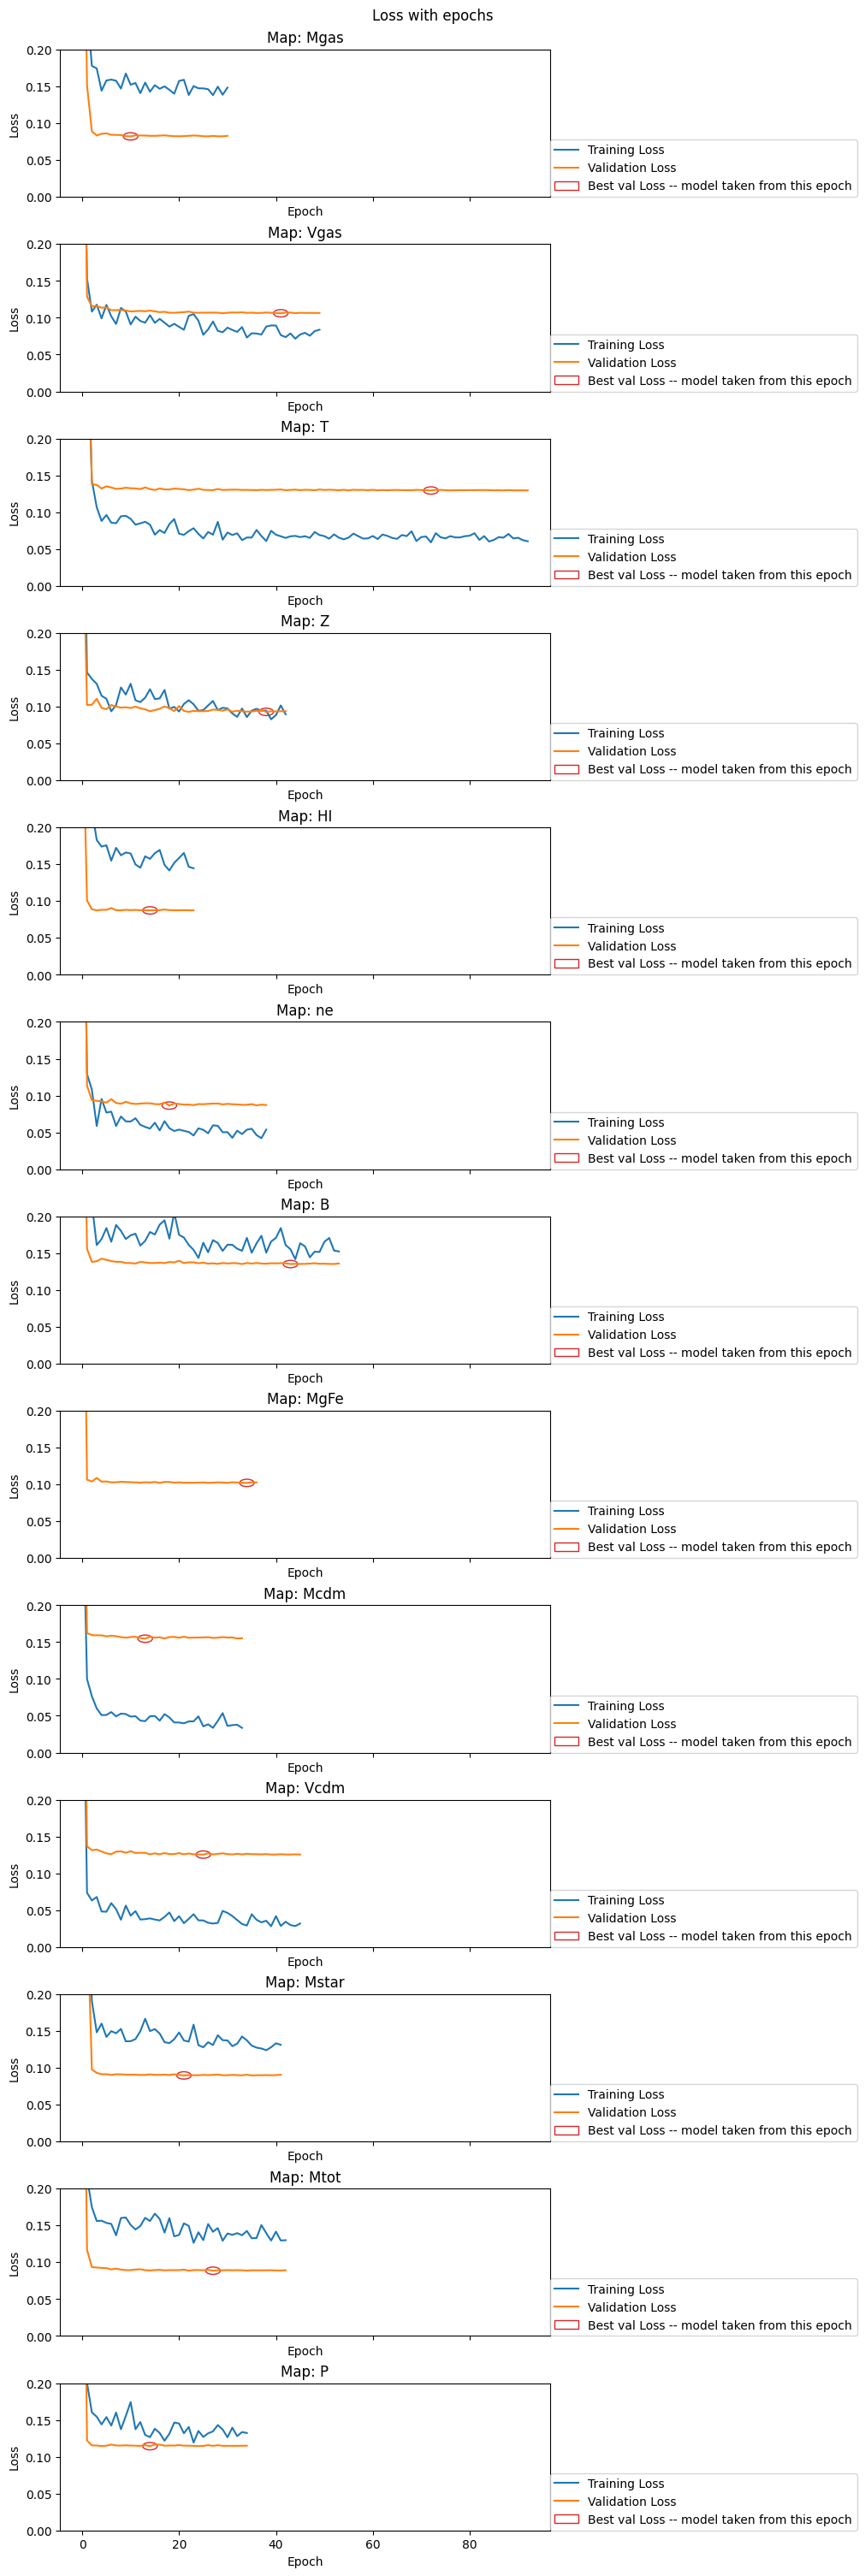

In [46]:
# Plotting loss with epochs for all models
# Plotting loss graphs

fig, ax = plt.subplots(13, figsize = (10, 30), sharey=True, sharex=True, constrained_layout=True)
plt.suptitle('Loss with epochs')
plt.ylim((0, 0.2))
for i, maps in enumerate(map_types):
    history = single_map_data[maps][2]
    ax[i].plot(history['train_loss_list'], label=f'Training Loss')
    ax[i].plot(history['val_loss_list'], label=f'Validation Loss')
    
    ls = np.min(history['val_loss_list'])
    ind = history['val_loss_list'].index(ls)

    circle = Ellipse((ind, ls), 3, 0.01, color='tab:red', fill=False, label="Best val Loss -- model taken from this epoch")
    ax[i].add_patch(circle)
    ax[i].legend(loc=(1,0))
    ax[i].set_title('Map: ' + maps)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')

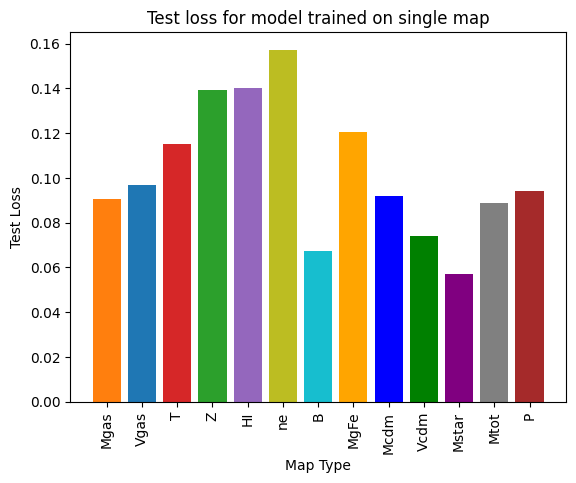

In [47]:
# Plotting bar graph of map type and test loss
test_loss_list_all = [single_map_data[maps][1] for maps in map_types]

colors = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:olive', 'tab:cyan', 'orange', 'blue', 'green', 'purple', 'grey', 'brown']

fig, ax = plt.subplots()
ax.bar(map_types, test_loss_list_all, color=colors)
plt.xticks(range(len(map_types)), map_types, rotation='vertical')
ax.set_title('Test loss for model trained on single map')
ax.set_ylabel('Test Loss')
ax.set_xlabel('Map Type');

NOTE: In this notebook we produce a lot graphs that are not included in the final report due to not being that helpful or not being that visually apealing.

Seeing how close the model predictions are to true values

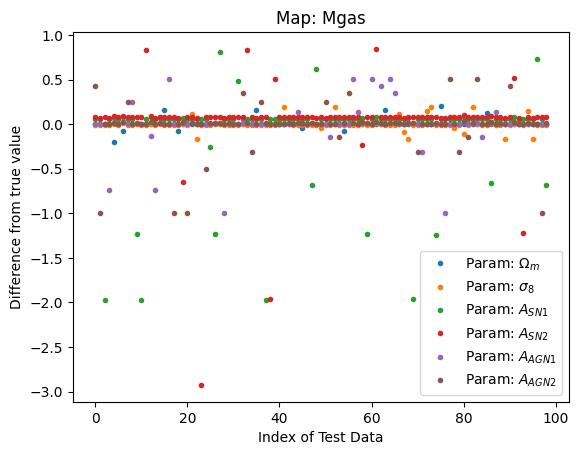

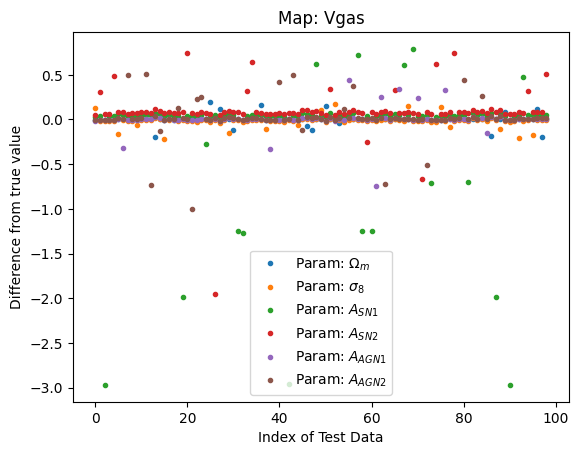

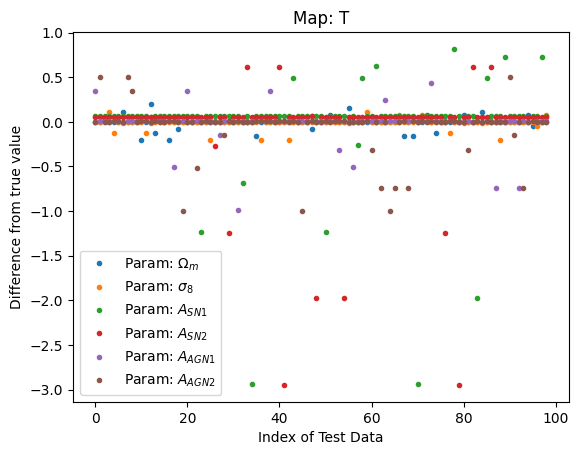

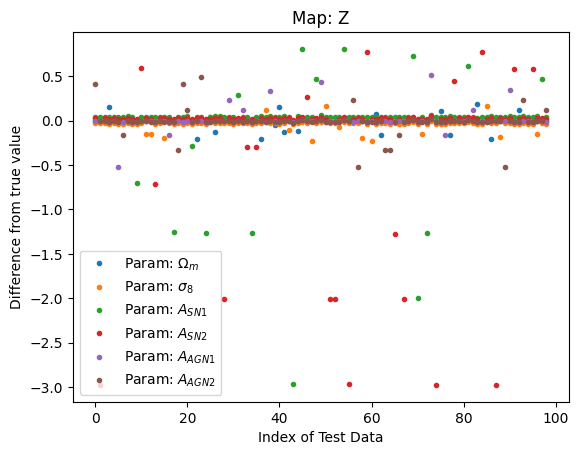

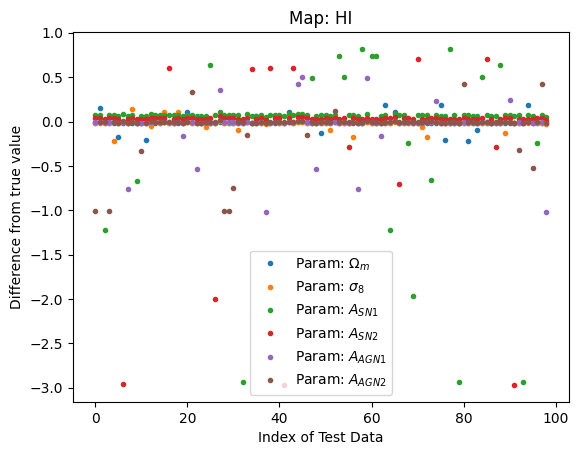

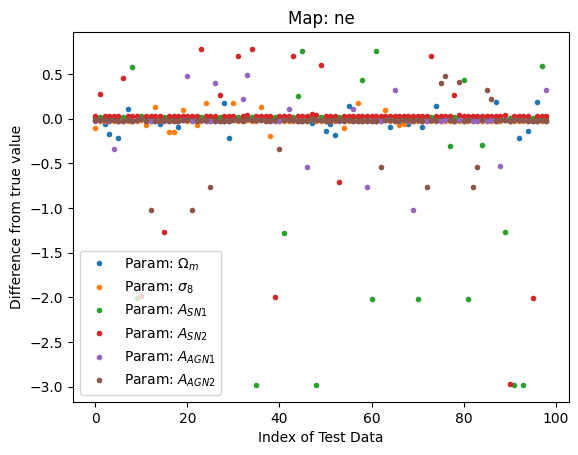

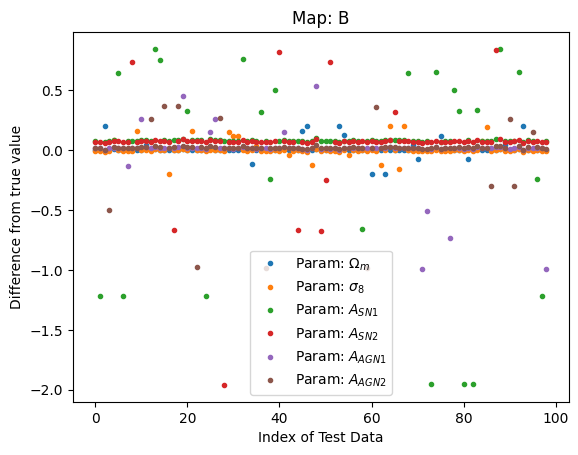

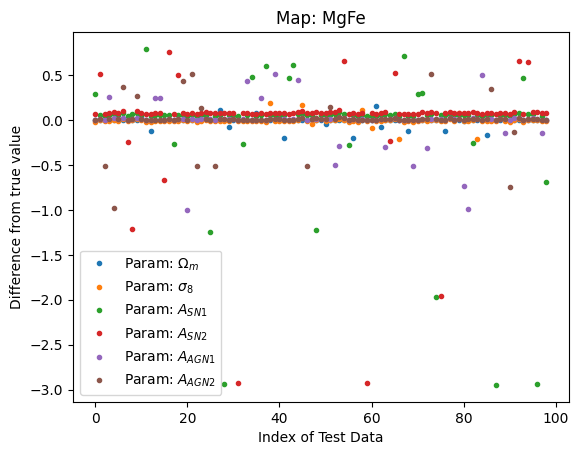

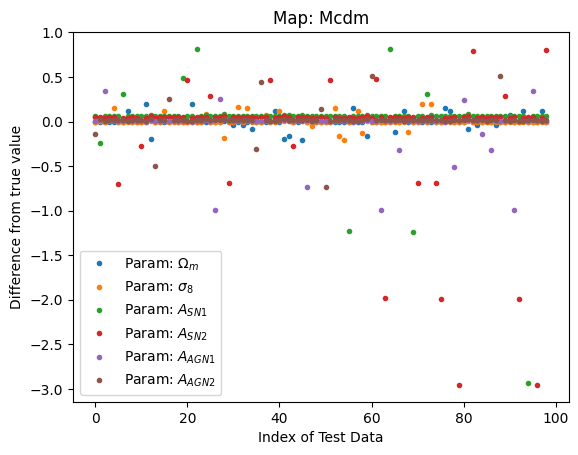

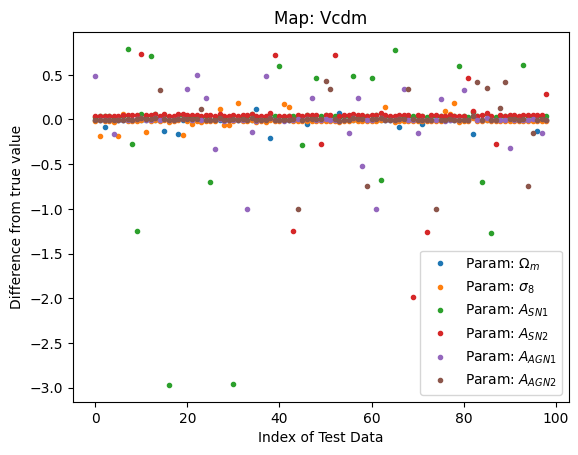

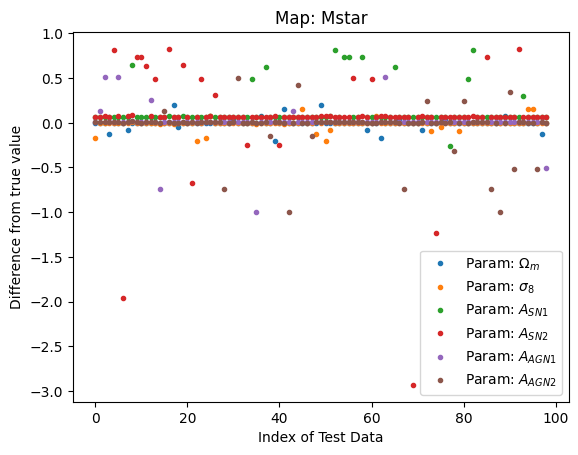

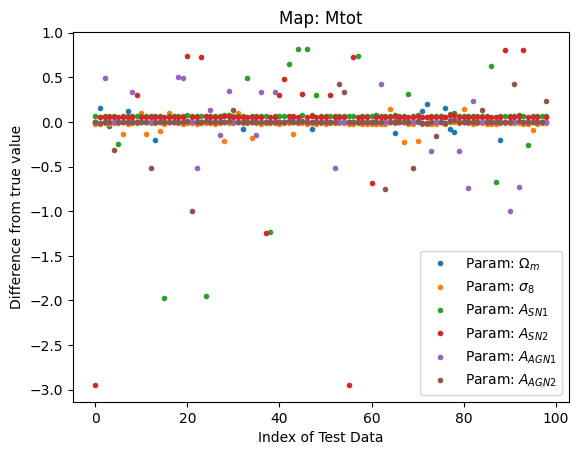

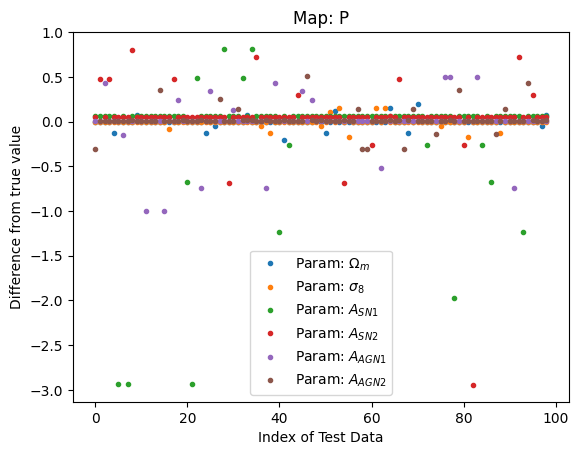

In [48]:
params = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$', r'$A_{SN2}$', r'$A_{AGN1}$', r'$A_{AGN2}$']
for i, map_diff in enumerate(differences):
    fig, ax = plt.subplots()
    for j in range(len(params)):
        map_diff = np.squeeze(np.array(map_diff))
        ax.plot(map_diff[:, j], '.', label=f'Param: {params[j]}', lw='0.4')
        ax.set_title(f'Map: {map_types[i]}')
        ax.set_ylabel('Difference from true value')
        ax.set_xlabel('Index of Test Data')
        ax.legend()

#### This is a bit ugly, can we make a nicer graph?

 We can do analysis of worst performing variables -- ie see which variables get predicted the worst across all maps
 We can also do average 'wrong-ness' from true value for each parameter across each map 

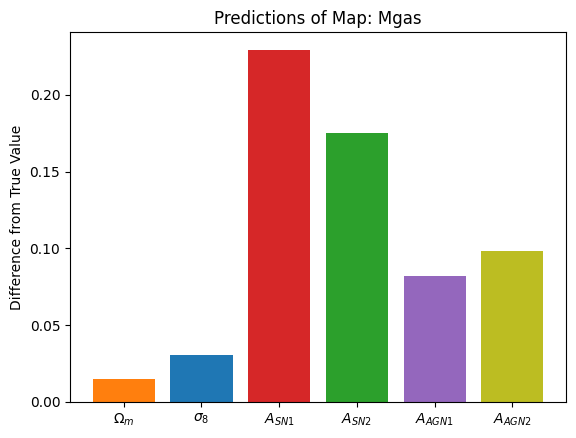

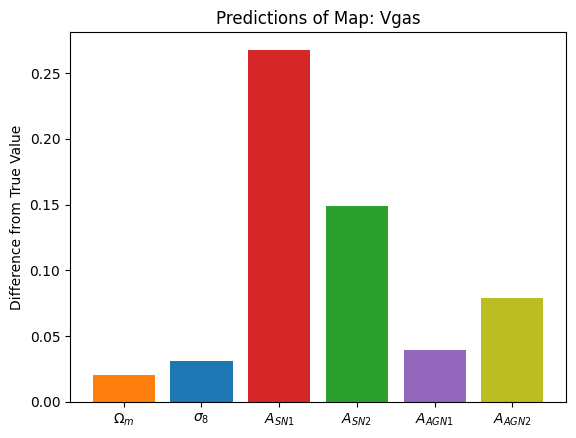

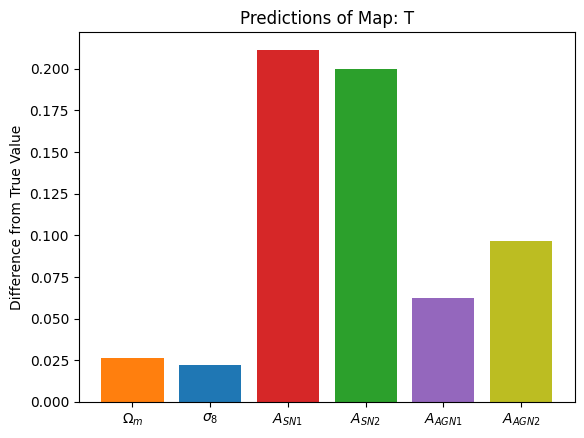

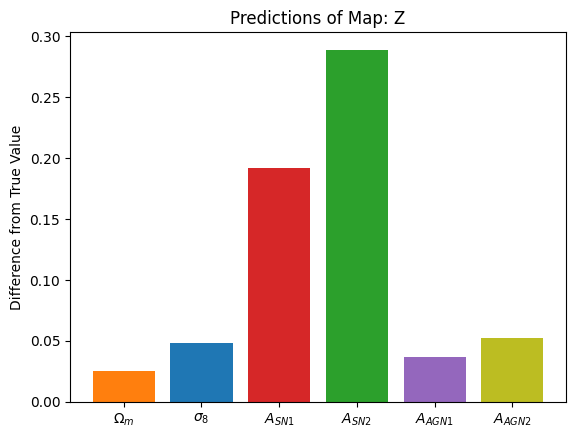

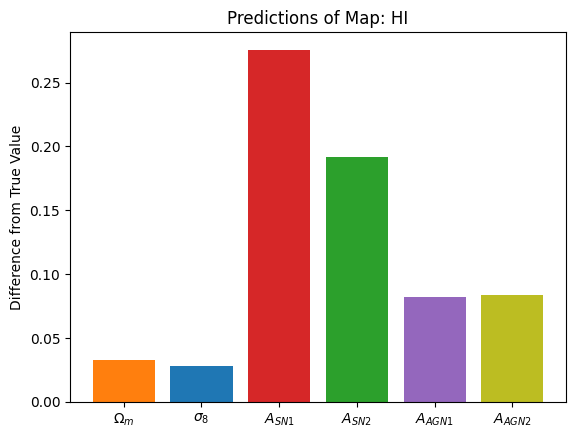

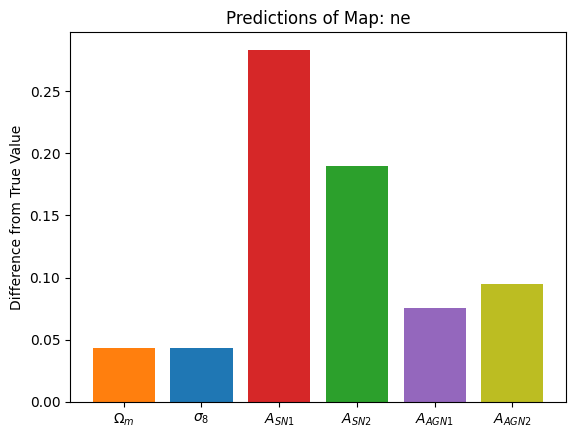

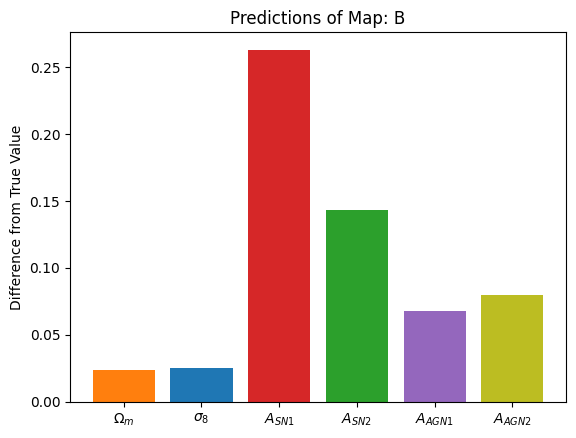

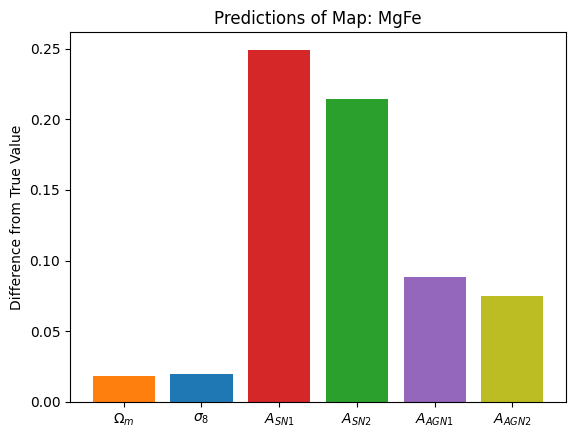

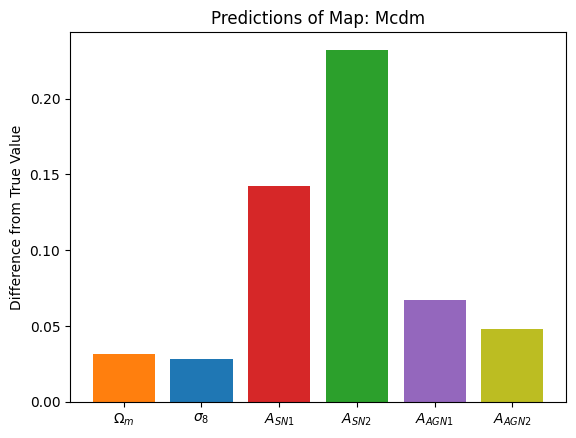

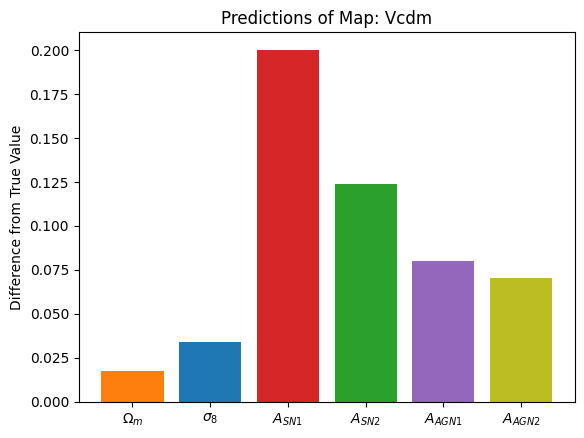

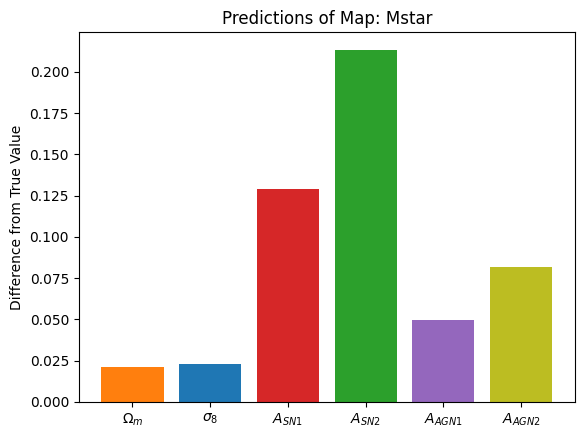

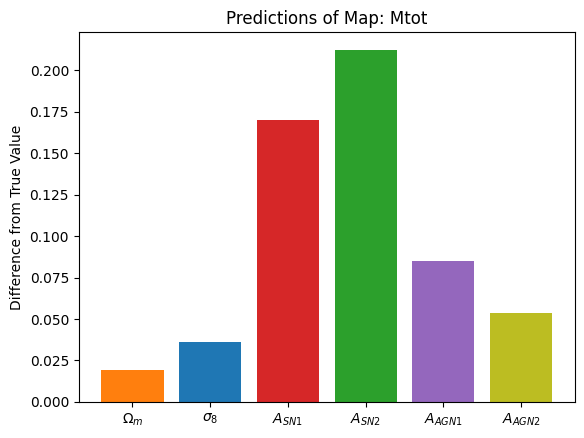

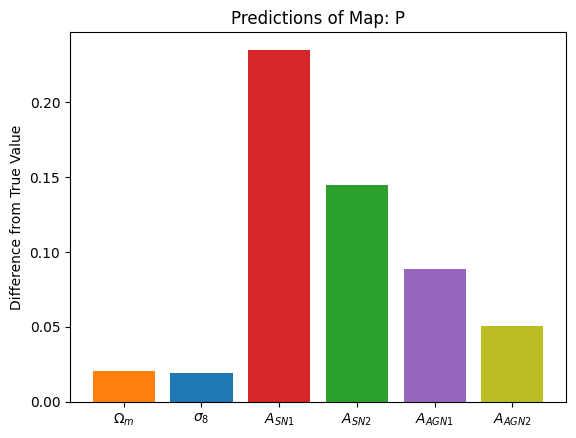

In [49]:
differences = np.squeeze(np.array(differences))
difference_sum = np.sum(np.abs(differences), axis=1) / differences.shape[1]

colors = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:olive', 'tab:cyan', 'orange', 'blue', 'green', 'purple', 'grey', 'brown']

for i, _map in enumerate(map_types):
    fig, ax = plt.subplots()
    ax.bar(params, difference_sum[i], color=colors)
    ax.set_title(f'Predictions of Map: {_map}')
    ax.set_ylabel('Difference from True Value')
    

From these graphs it is easy to see that most of our 'incorrectness' in the test data is coming from A parameters in particular $A_{SN1}$ and $A_{SN2}$. This is quite possibly due to them being the varibales that vary most in their values as well however, we will investigate this below.

Text(0, 0.5, 'Difference from True Value')

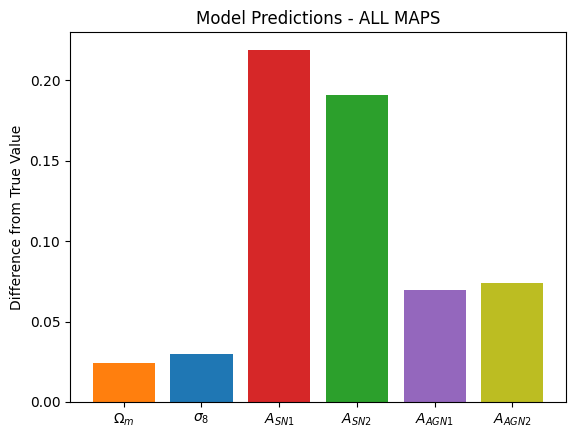

In [50]:
# Collapsing all differences into one graph

total_difference_sum = np.sum(difference_sum, axis=0) / difference_sum.shape[0]

fig, ax = plt.subplots()
ax.bar(params, total_difference_sum, color=colors)

ax.set_title('Model Predictions - ALL MAPS')
ax.set_ylabel("Difference from True Value")

Text(0, 0.5, '% Error')

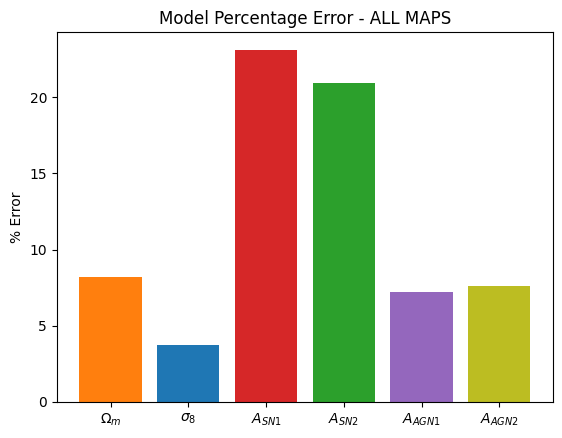

In [51]:
# Plotting percentage Error

error = np.abs(differences) / y_test.numpy() * 100

tot_error_sum = np.sum(np.sum(error, axis=1) / error.shape[1], axis=0) / error.shape[0]

fig, ax = plt.subplots()
ax.bar(params, tot_error_sum, color=colors)

ax.set_title('Model Percentage Error - ALL MAPS')
ax.set_ylabel("% Error")

Now see if the added difference from true value for A terms is correlated to varience of the input data for that field.

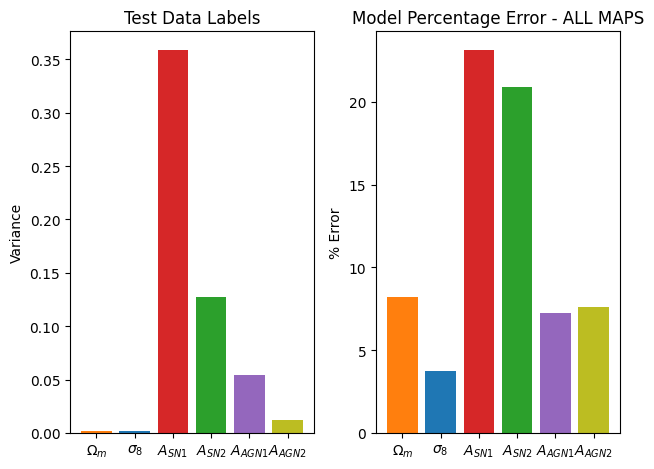

In [52]:
variance = np.var(y_test.numpy(), axis=0)

fig, ax = plt.subplots(1, 2, tight_layout=True)
ax[0].bar(params, variance, color=colors)

ax[0].set_title('Test Data Labels')
ax[0].set_ylabel("Variance")

ax[1].bar(params, tot_error_sum, color=colors)

ax[1].set_title('Model Percentage Error - ALL MAPS')
ax[1].set_ylabel("% Error");

Analysis: From this we can see there is definitely a link between increased data variance and error of the model, however they are not anywhere near as close as I expected them to be. 
 

## Possible Extension:
1. Train a machine learning algortithm on one field and use it to predict the cosmological parameters on other fields

In this section we will use the models we trained on one map to see how they perform (MSE loss) on all other maps

In [53]:
test_losses = {
    maps: [] for maps in map_types
}
trained_models = [data[0] for data in single_map_data.values()]
for i, model in enumerate(trained_models):
    other_maps = map_types.copy()
    other_maps.remove(map_types[i])
    for maps in other_maps:
        # Generate the data
        CAMELS_dataset = CAMELS_LOADER.CAMELS_Dataset([])
        CAMELS_dataset.add_maps([maps], verbose=False)
        CAMELS_dataset.generate_dataset()
        CAMELS_dataset.normalise()
        x_test = CAMELS_dataset.test_x
        y_test = CAMELS_dataset.test_y
        # Convert data from numpy to torch
        x_test = torch.from_numpy(x_test).unsqueeze(1).float()
        y_test = torch.from_numpy(y_test).float()
        
        test_loss = ModelTraining.test_model(x_test, y_test, model)
        
        test_losses[maps].append(test_loss)
        

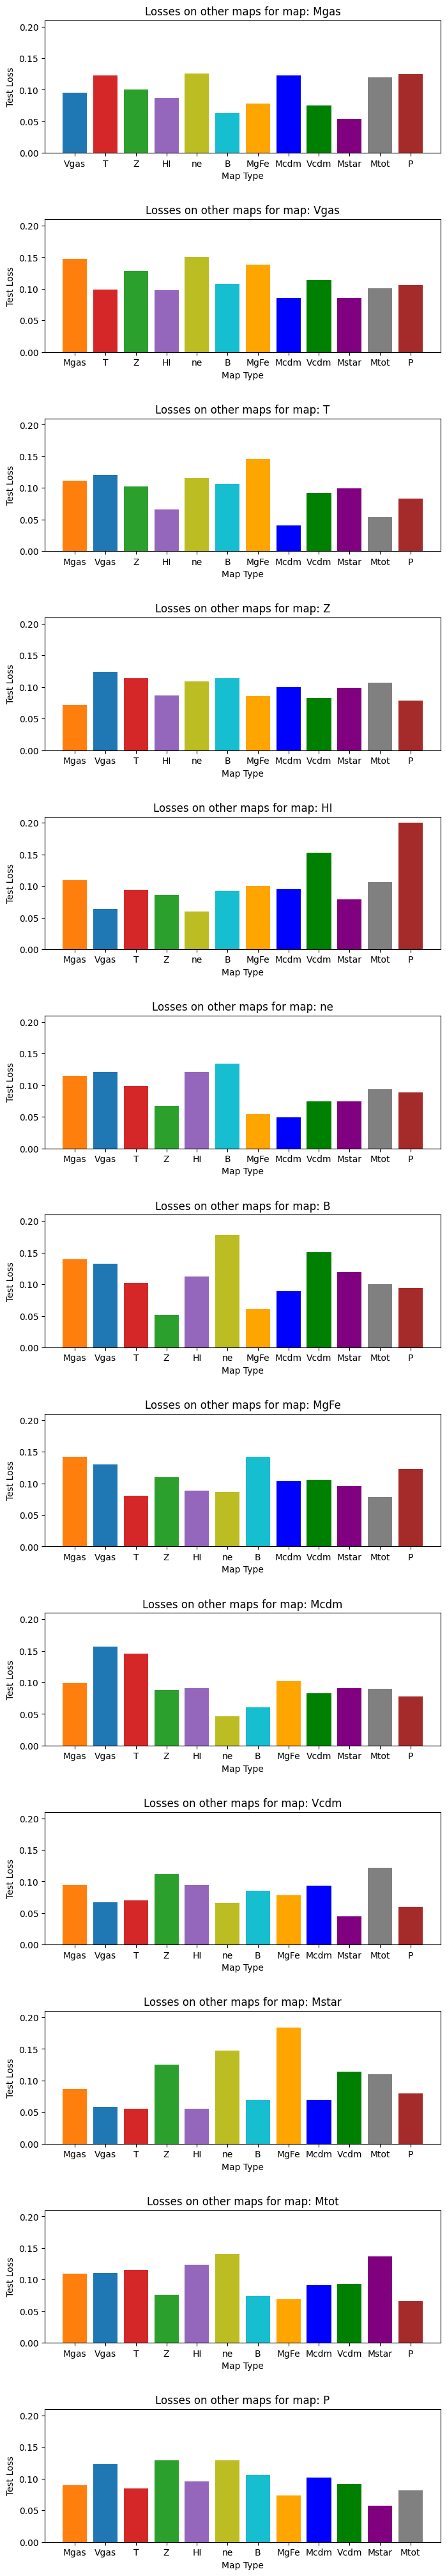

In [54]:
# Plot bar graphs for all models and the test loss for the other models

fig, ax = plt.subplots(13, sharey=True, figsize=(8, 5))
plt.subplots_adjust(top=8, hspace=0.5)
for i, maps in enumerate(map_types):
    loss_list = test_losses[maps]
    maps_copy = map_types.copy()
    maps_copy.remove(maps)
    local_colours = colors.copy()
    del local_colours[i]
    ax[i].bar(maps_copy, loss_list, color=local_colours)
    ax[i].set_title(f'Losses on other maps for map: {maps}')
    ax[i].set_ylabel('Test Loss')
    ax[i].set_xlabel('Map Type')
    

Text(0, 0.5, 'Mean loss on other maps')

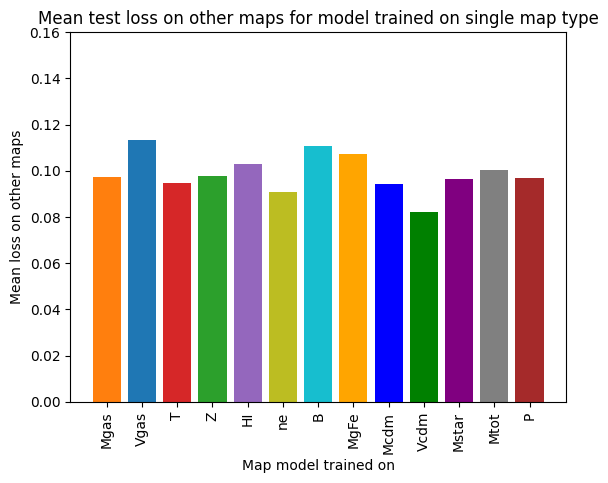

In [292]:
# Plotting average loss on other maps
average_losses = []


for i, maps in enumerate(map_types): 
    loss_list = test_losses[maps]
    average_losses.append(np.mean(loss_list))

fig, ax = plt.subplots()

ax.bar(map_types, average_losses, color=colors)


ax.set_title("Mean test loss on other maps for model trained on single map type")
plt.xticks(range(len(map_types)), map_types, rotation='vertical')
plt.ylim(0, 0.16)
ax.set_xlabel("Map model trained on")
ax.set_ylabel("Mean loss on other maps")

2. Train a machine learning algorithm to predict the cosmological parameters from multiple maps (e.g. of different fields at the same time)

There are 2 possible ways of doing this: we can either train the same model on multiple maps at the same time but with no relation that one map relates to another map other than it predicts the same outcome.

The other way of doing it is making the input channel the same depth as the number of maps loaded so that the model can get both images 'at the same time' to work out the parameters.

I suspect the second method will lead to better results (MSE loss), however I will test both scenarios to find out.  

1st Method: Just feed in extra maps as full dataset

For training model on all combinations of maps there are 8177 combinations, the full training run would therefore probably take over 20h, this is therefore not a possibility.

I will therefore just use a few example combinations

In [57]:
from itertools import combinations
from random import choices

In [58]:
def get_combinations(lst):
    """
    Returns all combinations of a list
    :param lst: 
    :return: list
    """
    combination = []
    for i in range(2, len(lst)):
        combination.extend(combinations(lst, i))
    return combination

In [59]:
map_combinations = get_combinations(map_types)
print(len(map_combinations))

8177


In [61]:
# Reduce the amount of combinations to try to a more reasonable number -- max_len_comb * comb_per_map_comb

comb_per_map_comb = 20
max_len_comb = 5

grouped_map_comb = {}
for comb in map_combinations:
    length = len(comb)
    if length > max_len_comb:
        break
    if length not in grouped_map_comb:
        grouped_map_comb[length] = []
    grouped_map_comb[length].append(comb)
reduced_map_combinations = []  
for value in grouped_map_comb.values():
    reduced_map_combinations.append(choices(value, k=comb_per_map_comb))
    
map_combinations = [item for sublist in reduced_map_combinations for item in sublist]

print(len(map_combinations))

80


In [62]:
importlib.reload(ModelTraining)

<module 'ModelTraining' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\ModelTraining.py'>

In [63]:
# Run the training loop for all parameter groups
# Set up dictionary to store data
mult_map_data = {
    ma: ['trained model', 'test loss', 'history'] for ma in map_combinations
}

for maps in map_combinations:
    # ----------------------------------- MODEL TRAINING -----------------------------------
    print('Maps:', maps)

    # Set up data
    CAMELS_dataset = CAMELS_LOADER.CAMELS_Dataset([])
    CAMELS_dataset.add_maps(list(maps), verbose=False)
    CAMELS_dataset.generate_dataset()
    CAMELS_dataset.normalise()

    # Generate the model
    config = best_config
    
    # Train for longer
    config['epochs'] = 200
    config['patience_self'] = 20
    config['tolerance_self'] = 0.0001

    model = HyperTuneTorch.NeuralNetwork(config)
    
    X_train = CAMELS_dataset.train_x
    y_train = CAMELS_dataset.train_y
    X_val = CAMELS_dataset.val_x
    y_val = CAMELS_dataset.val_y
    x_test = CAMELS_dataset.test_x
    y_test = CAMELS_dataset.test_y
    
    # Convert data from numpy to torch
    X_train = torch.from_numpy(X_train).unsqueeze(1).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).unsqueeze(1).float()
    y_val = torch.from_numpy(y_val).float()
    x_test = torch.from_numpy(x_test).unsqueeze(1).float()
    y_test = torch.from_numpy(y_test).float()

    # Train the model
    mult_map_data[maps][2], model = ModelTraining.train_model(config, X_train, y_train, X_val, y_val, model, verbose=False)

    mult_map_data[maps][0] = model  # Save the model for future use

    # Evaluate loss on training data
    test_loss = ModelTraining.test_model(x_test, y_test, model)
    mult_map_data[maps][1] = test_loss
    print(f'Model test loss for field(s) {list(CAMELS_dataset.maps.keys())}: {test_loss}')
    
    # Garbage collection for RAM storage
    del CAMELS_dataset, model
    gc.collect()

Maps: ('T', 'Vcdm')
Model loaded from epoch 26 with loss -- 0.08707838505506516
Model test loss for field(s) ['Vcdm', 'T']: 0.0755758062005043
Maps: ('ne', 'B')
Model loaded from epoch 61 with loss -- 0.09384782612323761
Model test loss for field(s) ['ne', 'B']: 0.08737445622682571
Maps: ('Vgas', 'Mstar')
Model loaded from epoch 43 with loss -- 0.10775522887706757
Model test loss for field(s) ['Vgas', 'Mstar']: 0.1148303747177124
Maps: ('Mtot', 'P')
Model loaded from epoch 13 with loss -- 0.08009317517280579
Model test loss for field(s) ['Mtot', 'P']: 0.07902389764785767
Maps: ('Mcdm', 'P')
Model loaded from epoch 8 with loss -- 0.08285024017095566
Model test loss for field(s) ['Mcdm', 'P']: 0.06859633326530457
Maps: ('T', 'MgFe')
Model loaded from epoch 16 with loss -- 0.11133991181850433
Model test loss for field(s) ['T', 'MgFe']: 0.10832833498716354
Maps: ('ne', 'Mtot')
Model loaded from epoch 8 with loss -- 0.10061118751764297
Model test loss for field(s) ['ne', 'Mtot']: 0.09770696

Plotting of losses:
As we have so many combinations of maps plotting 80 bar graphs wouldn't be useful as you wouldn't actually be able to see anything. Instead we will just plot the best performing 20 combinations. We will also then plot graphs of test loss with increasing map number.

In [64]:
# Getting the maps with the best loss
maps_in_loss_order = dict(sorted(mult_map_data.items(), key=lambda x:x[1][1]))

# Plotting bar graph of map type and test loss
test_loss_list_20 = list(maps_in_loss_order.values())[:20]

# Get all map types and their costs
loss_elements = [sublist[1] for sublist in test_loss_list_20]
mult_maps_list_20 = list(maps_in_loss_order.keys())[:20]
mult_maps_list_20 = [str(ma)[1:-1].replace("'", "") for ma in mult_maps_list_20]

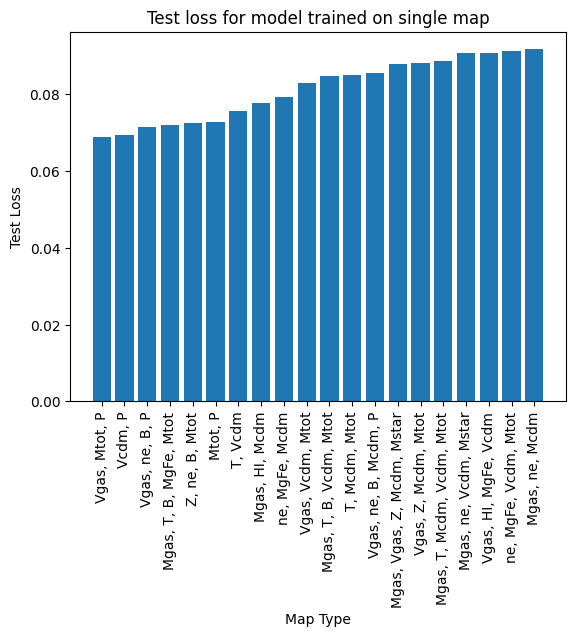

In [65]:
fig, ax = plt.subplots()
ax.bar(mult_maps_list_20, loss_elements)
plt.xticks(range(len(mult_maps_list_20)), mult_maps_list_20, rotation='vertical')
ax.set_title('Test loss for model trained on single map')
ax.set_ylabel('Test Loss')
ax.set_xlabel('Map Type');

Plotting loss with number of maps

In [72]:
# Grouping losses with number of maps
from collections import defaultdict

grouped_values = defaultdict(list)

for key, value in mult_map_data.items():
    key_length = len(key)
    grouped_values[key_length].append(value[1])

# Getting average loss for all map number groups
for key, value in grouped_values.items():
    grouped_values[key] = np.mean(value)

Text(0.5, 1.0, 'Comparing number of maps model trained on and loss')

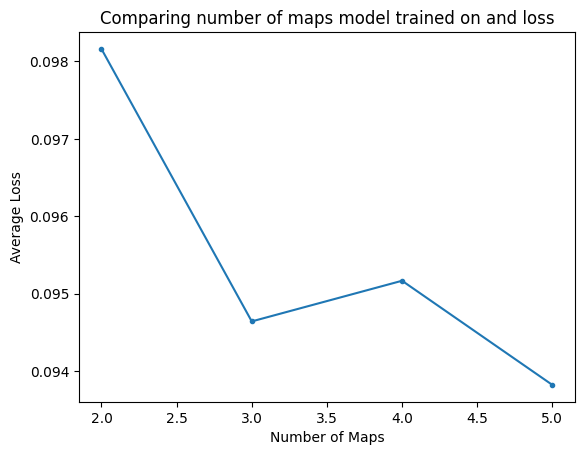

In [73]:
# Make the plot of loss with number of maps

fig, ax = plt.subplots()

ax.plot(list(grouped_values.keys()), list(grouped_values.values()), '.-')
ax.set_xlabel('Number of Maps')
ax.set_ylabel('Average Loss')
ax.set_title('Comparing number of maps model trained on and loss')

#### Testing the other method - Giving the model the extra dimensions / channels at the same time rather than separate images


In [74]:
# Example showing shape of arrays for multi-channel

multi_channel_dataset = CAMELS_LOADER.CAMELS_Dataset(['B'])
multi_channel_dataset.add_maps(['T'])
multi_channel_dataset.generate_dataset(channels=True)
print(multi_channel_dataset.train_x.shape)
print(multi_channel_dataset.train_y.shape)

File Maps_B_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
File Maps_T_IllustrisTNG_1P_z=0.00.npy already on system, skipping download...
All new maps loaded. Call method generate_dataset to regenerate the new dataset for the new maps
(792, 256, 256, 2)
(792, 6)


In [75]:
importlib.reload(ModelTraining)
importlib.reload(CAMELS_LOADER)

<module 'CAMELS_LOADER' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\CAMELS_LOADER.py'>

In [77]:
# Run the training loop for all parameter groups -- CHANNELS
# Set up dictionary to store data
mult_map_data_CHANNELS = {
    ma: ['trained model', 'test loss', 'history'] for ma in map_combinations
}

for maps in map_combinations[::-1]:
    # ----------------------------------- MODEL TRAINING -----------------------------------
    print('Maps:', maps)

    # Set up data
    CAMELS_dataset = CAMELS_LOADER.CAMELS_Dataset([])
    CAMELS_dataset.add_maps(list(maps), verbose=False)
    CAMELS_dataset.generate_dataset(channels=True)
    CAMELS_dataset.normalise(channels=True)
    # Generate the model
    config = best_config
    
    # Train for longer
    config['epochs'] = 200
    config['batch_size'] = 64
    config['patience_self'] = 20
    config['tolerance_self'] = 0.0001
    config['input_shape'] = (len(maps), 256, 256)
    config['in_channels'] = len(maps)

    model = HyperTuneTorch.NeuralNetwork(config)
    
    
    X_train = CAMELS_dataset.train_x
    y_train = CAMELS_dataset.train_y
    X_val = CAMELS_dataset.val_x
    y_val = CAMELS_dataset.val_y
    x_test = CAMELS_dataset.test_x
    y_test = CAMELS_dataset.test_y
    
    # Convert data from numpy to torch
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Train the model
    mult_map_data_CHANNELS[maps][2], model = ModelTraining.train_model(config, X_train, y_train, X_val, y_val, model, verbose=False)

    mult_map_data_CHANNELS[maps][0] = model  # Save the model for future use

    # Evaluate loss on training data
    test_loss = ModelTraining.test_model(x_test, y_test, model)
    mult_map_data_CHANNELS[maps][1] = test_loss
    print(f'Model test loss for field(s) {list(CAMELS_dataset.maps.keys())}: {test_loss}')


Maps: ('T', 'ne', 'Mcdm', 'Mstar', 'P')
Model loaded from epoch 46 with loss -- 0.11209337413311005
Model test loss for field(s) ['ne', 'Mstar', 'Mcdm', 'P', 'T']: 0.10943084210157394
Maps: ('T', 'Z', 'ne', 'Vcdm', 'Mtot')
Model loaded from epoch 46 with loss -- 0.11022409796714783
Model test loss for field(s) ['ne', 'Mtot', 'T', 'Vcdm', 'Z']: 0.07515458017587662
Maps: ('Mgas', 'T', 'Mcdm', 'Vcdm', 'Mtot')
Model loaded from epoch 23 with loss -- 0.11151281744241714
Model test loss for field(s) ['Mtot', 'Mgas', 'Mcdm', 'T', 'Vcdm']: 0.10181743651628494
Maps: ('Vgas', 'ne', 'B', 'Mcdm', 'P')
Model loaded from epoch 40 with loss -- 0.13142453134059906
Model test loss for field(s) ['ne', 'B', 'Vgas', 'Mcdm', 'P']: 0.11638522893190384
Maps: ('Vgas', 'T', 'Mcdm', 'Mtot', 'P')
Model loaded from epoch 35 with loss -- 0.09644690155982971
Model test loss for field(s) ['Vgas', 'Mtot', 'Mcdm', 'P', 'T']: 0.09803789854049683
Maps: ('Mgas', 'ne', 'Mstar', 'Mtot', 'P')
Model loaded from epoch 18 with

TypeError: NeuralNetwork.forward() missing 1 required positional argument: 'x'

In [78]:
# Getting the maps with the best loss
maps_in_loss_order_C = dict(sorted(mult_map_data_CHANNELS.items(), key=lambda x:x[1][1]))

# Plotting bar graph of map type and test loss
test_loss_list_20_C = list(maps_in_loss_order_C.values())[:20]

# Get all map types and their costs
loss_elements_C = [sublist[1] for sublist in test_loss_list_20_C]
mult_maps_list_20_C = list(maps_in_loss_order.keys())[:20]
mult_maps_list_20_C = [str(ma)[1:-1].replace("'", "") for ma in mult_maps_list_20_C]

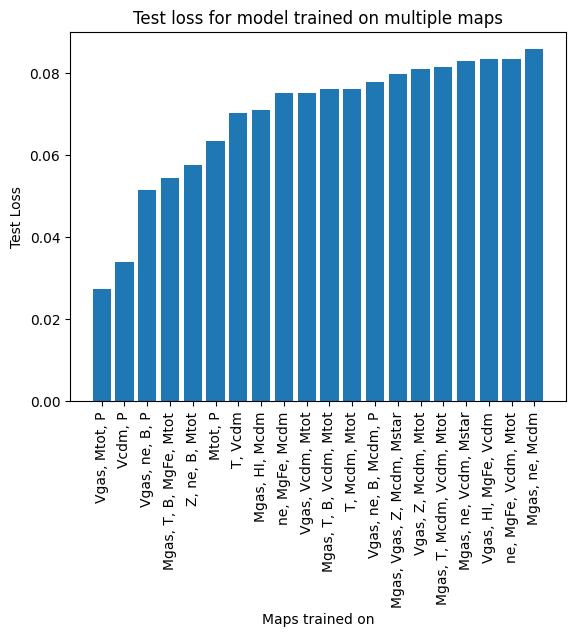

In [79]:
fig, ax = plt.subplots()
ax.bar(mult_maps_list_20_C, loss_elements_C)
plt.xticks(range(len(mult_maps_list_20_C)), mult_maps_list_20_C, rotation='vertical')
ax.set_title('Test loss for model trained on multiple maps')
ax.set_ylabel('Test Loss')
ax.set_xlabel('Maps trained on');

In [80]:
grouped_values_C = defaultdict(list)

for key, value in mult_map_data_CHANNELS.items():
    key_length = len(key)
    grouped_values_C[key_length].append(value[1])

# Getting average loss for all map number groups
for key, value in grouped_values_C.items():
    grouped_values_C[key] = np.mean(value)

Text(0.5, 1.0, 'Comparing number of maps model trained on and loss -- extra channels')

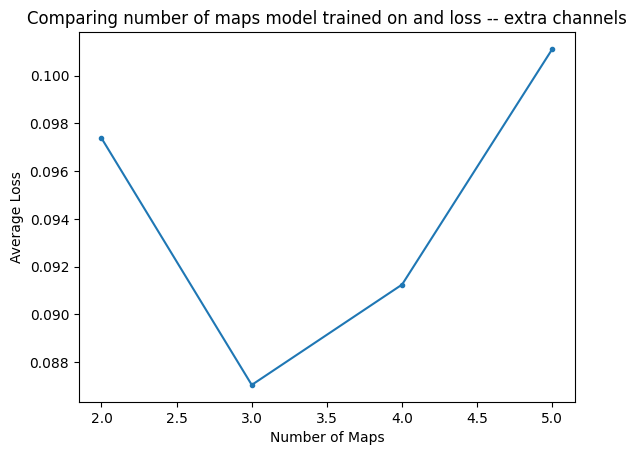

In [81]:
# Make the plot of loss with number of maps
fig, ax = plt.subplots()

ax.plot(list(grouped_values_C.keys()), list(grouped_values_C.values()), '.-')
ax.set_xlabel('Number of Maps')
ax.set_ylabel('Average Loss')
ax.set_title('Comparing number of maps model trained on and loss -- extra channels')

#### Comparing the two methods of combining images

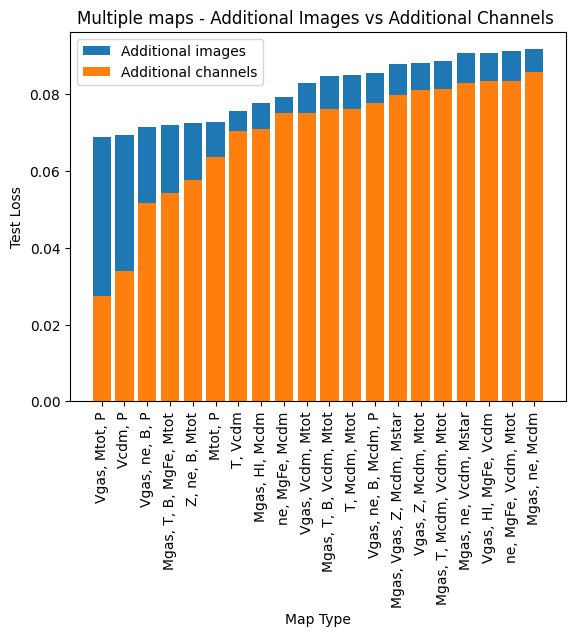

In [82]:
fig, ax = plt.subplots()
ax.bar(mult_maps_list_20, loss_elements, color='tab:blue', label='Additional images')
plt.xticks(range(len(mult_maps_list_20)), mult_maps_list_20, rotation='vertical')
ax.set_title('Test loss for model trained on single map')
ax.set_ylabel('Test Loss')
ax.set_xlabel('Map Type')

ax.bar(mult_maps_list_20_C, loss_elements_C, color='tab:orange', label='Additional channels')
plt.xticks(range(len(mult_maps_list_20_C)), mult_maps_list_20_C, rotation='vertical')
ax.set_title('Multiple maps - Additional Images vs Additional Channels ')
ax.set_ylabel('Test Loss')
ax.set_xlabel('Map Type')

plt.legend();

In [83]:
single_avg_loss = np.mean(test_loss_list_all)

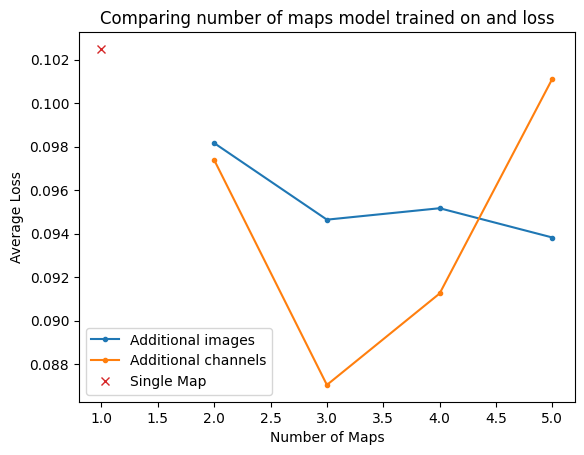

In [84]:
# Make the plot of loss with number of maps

fig, ax = plt.subplots()
# MULTIPLE IMAGES
ax.plot(list(grouped_values.keys()), list(grouped_values.values()), '.-', color='tab:blue', label='Additional images')
ax.set_xlabel('Number of Maps')
ax.set_ylabel('Average Loss')
ax.set_title('Comparing number of maps model trained on and loss')

# MULTIPLE CHANNELS
ax.plot(list(grouped_values_C.keys()), list(grouped_values_C.values()), '.-', color='tab:orange', label='Additional channels')

# SINGLE MAP
ax.plot(1, single_avg_loss, 'x', color='tab:red', label='Single Map')

plt.legend()

Include a way of telling which maps are actually useful

eg Map against number of times occuring in best maps to use

In [98]:
print(mult_maps_list_20_C)

['Vgas, Mtot, P', 'Vcdm, P', 'Vgas, ne, B, P', 'Mgas, T, B, MgFe, Mtot', 'Z, ne, B, Mtot', 'Mtot, P', 'T, Vcdm', 'Mgas, HI, Mcdm', 'ne, MgFe, Mcdm', 'Vgas, Vcdm, Mtot', 'Mgas, T, B, Vcdm, Mtot', 'T, Mcdm, Mtot', 'Vgas, ne, B, Mcdm, P', 'Mgas, Vgas, Z, Mcdm, Mstar', 'Vgas, Z, Mcdm, Mtot', 'Mgas, T, Mcdm, Vcdm, Mtot', 'Mgas, ne, Vcdm, Mstar', 'Vgas, HI, MgFe, Vcdm', 'ne, MgFe, Vcdm, Mtot', 'Mgas, ne, Mcdm']
['Vgas']


Text(0.5, 1.0, 'Number of occurrences of maps in the 20 best map combinations')

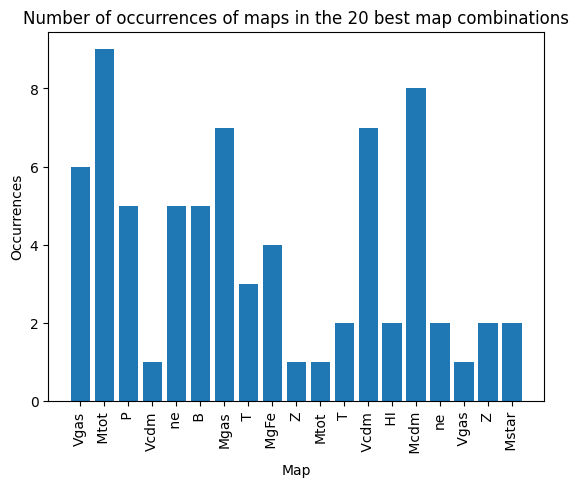

In [101]:
# Plotting number of occurrences of a certain map in the best 20 maps
from collections import Counter

flattened_list = ','.join(mult_maps_list_20_C).split(',')

# Count occurrences
counted_elements = Counter(flattened_list)


fig, ax = plt.subplots()
ax.bar(counted_elements.keys(), counted_elements.values())
plt.xticks(range(len(counted_elements.keys())), counted_elements.keys(), rotation='vertical')

ax.set_xlabel("Map")
ax.set_ylabel("Occurrences")
ax.set_title("Number of occurrences of maps in the 20 best map combinations")

Having found the best way of carrying out training on multiple maps (the lower loss and the much shorter training time), we can now test for more map combinations, including longer map combinations.

In [102]:
# Custom module for training multiple maps (Done to clean up notebook)
import MultipleMaps

In [276]:
importlib.reload(MultipleMaps)

<module 'MultipleMaps' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\MultipleMaps.py'>

In [283]:
MultipleMaps.run(1, 12, best_config)

Total Length of set:  11
Length of set not already tested:  9
Maps: ('Mgas', 'T', 'Z', 'HI', 'ne', 'MgFe', 'Vcdm', 'Mstar', 'Mtot')
Model loaded from epoch 55 with loss -- 0.08516835421323776
Model test loss for field(s) ['ne', 'Vcdm', 'HI', 'Mtot', 'MgFe', 'Mgas', 'Mstar', 'T', 'Z']: 0.10954627394676208
Maps: ('Mgas', 'B', 'Vcdm', 'Mtot')
Model loaded from epoch 36 with loss -- 0.08567416667938232
Model test loss for field(s) ['B', 'Mtot', 'Vcdm', 'Mgas']: 0.104946568608284
Maps: ('Mgas', 'Vgas', 'T', 'Z', 'HI', 'ne', 'B', 'Mcdm', 'Mstar', 'Mtot')
Model loaded from epoch 53 with loss -- 0.08537782728672028
Model test loss for field(s) ['ne', 'B', 'Vgas', 'HI', 'Mtot', 'Mgas', 'Mstar', 'Mcdm', 'T', 'Z']: 0.116579070687294
Maps: ('Mgas', 'T', 'Z', 'HI', 'Mstar', 'Mtot', 'P')
Model loaded from epoch 32 with loss -- 0.10914140194654465
Model test loss for field(s) ['HI', 'Mtot', 'Mstar', 'Mgas', 'P', 'T', 'Z']: 0.09665923565626144
Maps: ('Vgas', 'T', 'Z', 'HI', 'Mcdm', 'Mtot')
Model loade

In [284]:
MultipleMaps.run(200, 2, best_config)

Total Length of set:  200
Length of set not already tested:  0


Total number of map combinations tested: 685
Standard deviation of tested model combinations: 0.006369670434411359
Mean of tested model combinations: 0.05477207489311695


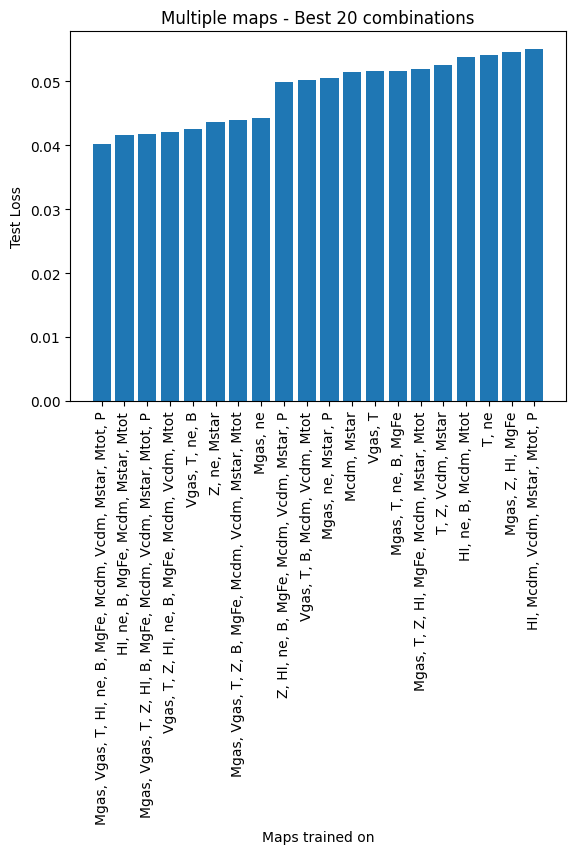

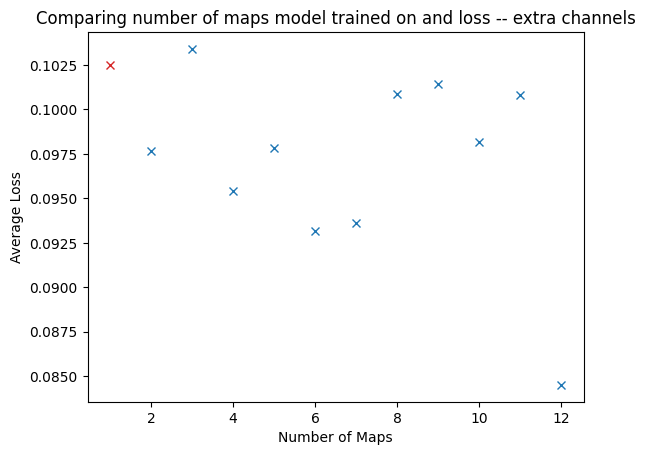

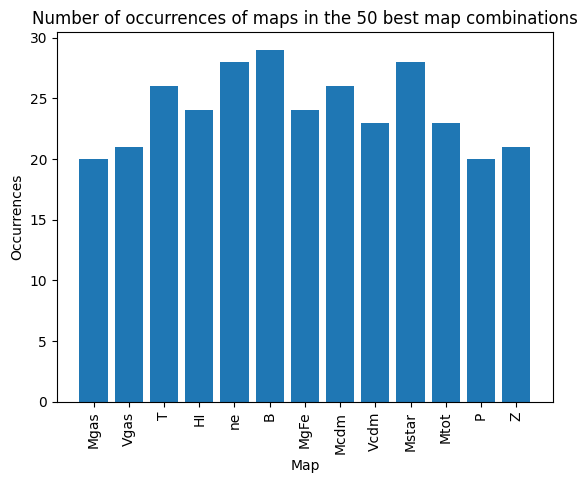

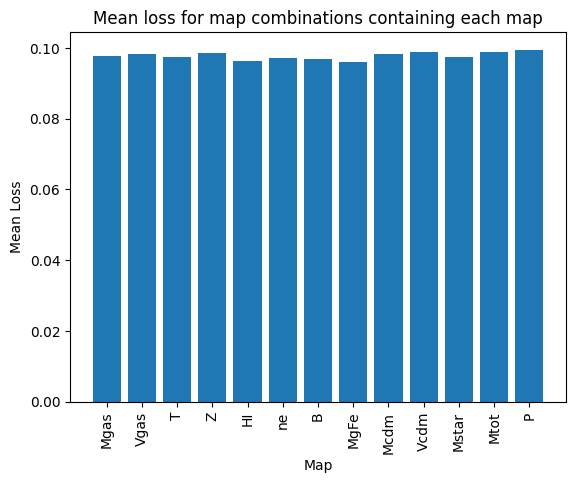

In [290]:
MultipleMaps.analysis(single_avg_loss)

In [289]:
importlib.reload(MultipleMaps)

<module 'MultipleMaps' from 'C:\\Users\\benje\\PycharmProjects\\PHAS0056\\MiniProject\\MultipleMaps.py'>

Total combinations of maps containing 2 different map types: 78
Loaded and tested combinations of maps containing 2 different map types: 78


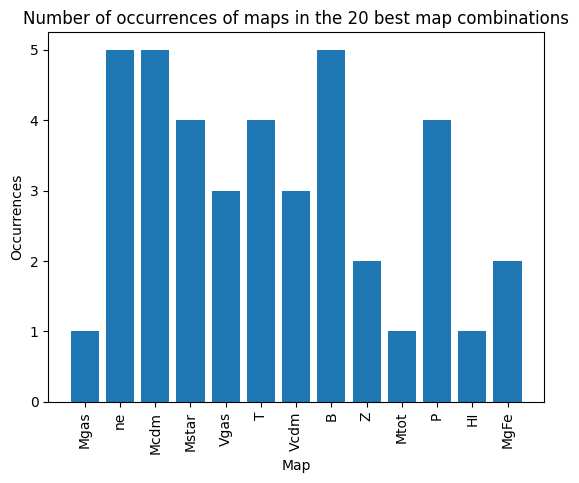

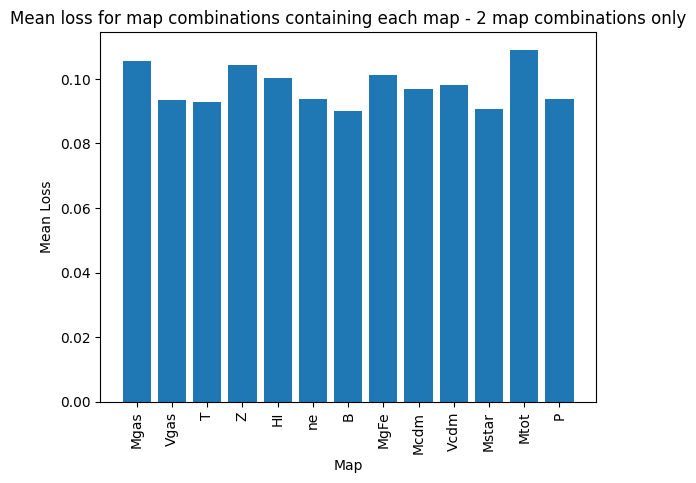

In [246]:
MultipleMaps.analysis_2_only()